In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pptoolbox.platform import preprocess, WAVELENGTHS_3NM_V1
from pptoolbox.platform.automl_v4 import AutoML_v4
from pptoolbox.platform.automl_v4.utils import cross_group_predict

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score

import warnings
warnings.simplefilter("ignore")

import pickle as pkl

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

# import data

In [64]:
raw_folder_path = "../data/raw"
raw_df = pd.read_csv(f"{raw_folder_path}/spectra_241023.csv")

label_all_df = pd.read_csv(f"../data/processed/label_all_241023.csv")
label_noAmb_df = pd.read_csv(f"../data/processed/label_noAmb_241023.csv")

raw_df.shape, label_all_df.shape,label_noAmb_df.shape

((438, 13), (109, 7), (91, 7))

In [65]:
raw_df.head()

,lot_id,specimen_id,lot_name,date_scanned,analyser_id,company_id,product_id,product_name,raw_data,dark_ref_data,white_ref_data,dark_ref_scan_time,white_ref_scan_time
0,81314,482082,SH3639-025,1729241208,26,1281,6624,Shortening (Rancidity),"[{""wavelength"": 332.4588623046875, ""reflectanc...","[11.282109375, 17.895625, 15.575234375, 17.175...","[11.20390625, 17.25265625, 15.479453125, 16.47...",1729240710,1729240737
1,81314,482083,SH3639-025,1729241228,26,1281,6624,Shortening (Rancidity),"[{""wavelength"": 332.4588623046875, ""reflectanc...","[11.282109375, 17.895625, 15.575234375, 17.175...","[11.20390625, 17.25265625, 15.479453125, 16.47...",1729240710,1729240737
2,81314,482084,SH3639-025,1729241244,26,1281,6624,Shortening (Rancidity),"[{""wavelength"": 332.4588623046875, ""reflectanc...","[11.282109375, 17.895625, 15.575234375, 17.175...","[11.20390625, 17.25265625, 15.479453125, 16.47...",1729240710,1729240737
3,81314,482085,SH3639-025,1729241260,26,1281,6624,Shortening (Rancidity),"[{""wavelength"": 332.4588623046875, ""reflectanc...","[11.282109375, 17.895625, 15.575234375, 17.175...","[11.20390625, 17.25265625, 15.479453125, 16.47...",1729240710,1729240737
4,81331,481986,SH3639-053,1729239429,26,1281,6624,Shortening (Rancidity),"[{""wavelength"": 332.4588623046875, ""reflectanc...","[10.82578125, 17.066953125, 15.0646875, 16.381...","[10.903125, 16.99671875, 15.00578125, 16.12343...",1729239190,1729239211


In [66]:
label_df = label_noAmb_df.pivot(index=['lot_id','lot_name'],columns='property_name',values='property_value').reset_index()
label_df

property_name,lot_id,lot_name,Rancidity (Class-text)
0,76751,SH3639-598,2Mild
1,76752,SH3639-A,1Pass
2,76753,SH3639-397,1Pass
3,76754,SH3639-486,3Rancid
4,76755,SH3639-208,2Mild
...,...,...,...
86,81327,SH3639-659,3Rancid
87,81328,SH3639-937,2Mild
88,81329,SH3639-950,1Pass
89,81330,SH3639-391,3Rancid


# train-test split random

In [98]:
# random split
label = label_df.set_index('lot_id')

sorted_idx = label.index.unique()
train_label, test_label = train_test_split(label.loc[sorted_idx], test_size=0.1, stratify=label.loc[sorted_idx]['Rancidity (Class-text)'],
                                           shuffle=True, random_state=42)

train_label.shape, test_label.shape

((81, 2), (10, 2))

In [99]:
train_idx = train_label.index
test_idx = test_label.index

save_dir = "../data/processed/"

X_train = raw_df.set_index('lot_id').loc[train_idx]
X_test = raw_df.set_index('lot_id').loc[test_idx]
y_train = label_df.set_index('lot_id').loc[X_train.index]
y_test = label_df.set_index('lot_id').loc[X_test.index]

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

X_train.to_csv(f'{save_dir}/Xtrain.csv')
X_test.to_csv(f'{save_dir}/Xtest.csv')
y_train.to_csv(f'{save_dir}/ytrain.csv')
y_test.to_csv(f'{save_dir}/ytest.csv')

X_train = X_train.reset_index()
X_test = X_test.reset_index()
y_train = y_train.reset_index()
y_test = y_test.reset_index()

(325, 12) (325, 2) (40, 12) (40, 2)


# train-test split by date

In [80]:
val_df = raw_df[raw_df['date_scanned'] > 1727654400]
raw_df = raw_df[raw_df['date_scanned'] < 1727654400]
raw_df.shape, val_df.shape

((940, 11), (96, 11))

In [81]:
label_train = label_df[label_df['lot_id'].isin(raw_df['lot_id'])]
label_train.to_csv('../data/train_list.csv')

# preprocess

In [100]:
y_train = y_train.drop_duplicates().drop(columns = ['lot_name'])
y_test = y_test.drop_duplicates().drop(columns = ['lot_name'])

In [101]:
X_train, y_train = preprocess(X_train, y_train,  wavelengths=WAVELENGTHS_3NM_V1)
X_test, y_test = preprocess(X_test, y_test,  wavelengths=WAVELENGTHS_3NM_V1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((325, 191), (325, 1), (40, 191), (40, 1))

# Classify

In [102]:
encoder = LabelEncoder()
y_train_encoded = pd.Series(
    encoder.fit_transform(y_train),
    index = y_train.index
)

pkl.dump(encoder, open("../models/automl/encoder.pkl", "wb"))

X_train.shape, y_train_encoded.shape

((325, 191), (325,))

In [103]:
trainer = AutoML_v4(task_type = "classify")
trainer.fit(X_train, y_train_encoded)
pkl.dump(trainer, open(
    "../models/automl/trainer.pkl", "wb"
))

 88%|████████▊ | 177/200 [01:03<00:08,  2.80trial/s, best loss: 0.2891013307679974]


In [104]:
trainer=pkl.load(open('../models/automl/trainer.pkl','rb'))

In [105]:
trainer.get_best_trial()

{'state': 2,
 'tid': 101,
 'spec': None,
 'result': {'loss': 0.2891013307679974,
  'cv_results': {'train_balanced_accuracy': 0.8110989118235495,
   'test_balanced_accuracy': 0.7108986692320026,
   'train_f1_micro': 0.8124688830277199,
   'test_f1_micro': 0.7162528829195495,
   'train_precision_micro': 0.8124688830277199,
   'test_precision_micro': 0.7162528829195497,
   'train_recall_micro': 0.8124688830277199,
   'test_recall_micro': 0.7162528829195497},
  'time_taken': 0.34583497047424316,
  'pipeline': Pipeline(steps=[('SG2D', SavitzkyGolay(deriv=2, window=17)),
                  ('Scaler', StandardScaler(with_std=False)),
                  ('PCA', PCA(n_components=17, random_state=42)),
                  ('LDA', LinearDiscriminantAnalysis())]),
  'status': 'ok',
  'exception': None},
 'misc': {'tid': 101,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'C': [],
   'alpha': [],
   'ccp_alpha': [],
   'classifier': [101],
   'dimred_choice': [],
   'k

In [106]:
trainer.get_pipeline()

Pipeline(steps=[('SG2D', SavitzkyGolay(deriv=2, window=17)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=17, random_state=42)),
                ('LDA', LinearDiscriminantAnalysis())])

# platform model

In [88]:
platform_trainer=pkl.load(open('../models/platform/6089/prediction/trainer.pkl','rb'))

In [89]:
platform_trainer.get_best_trial()

{'state': 2,
 'tid': 137,
 'spec': None,
 'result': {'loss': 0.13482142857142865,
  'cv_results': {'train_balanced_accuracy': 0.9195262959402992,
   'test_balanced_accuracy': 0.8651785714285714,
   'train_f1_micro': 0.8946696880614077,
   'test_f1_micro': 0.8471275559883155,
   'train_precision_micro': 0.8946696880614078,
   'test_precision_micro': 0.8471275559883155,
   'train_recall_micro': 0.8946696880614078,
   'test_recall_micro': 0.8471275559883155},
  'time_taken': 0.38838720321655273,
  'pipeline': Pipeline(steps=[('SG2D', SavitzkyGolay(deriv=2, window=13)),
                  ('Scaler', StandardScaler(with_std=False)),
                  ('PCA', PCA(n_components=23, random_state=42)),
                  ('QDA', QuadraticDiscriminantAnalysis())]),
  'status': 'ok',
  'exception': None},
 'misc': {'tid': 137,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'C': [],
   'alpha': [],
   'ccp_alpha': [],
   'classifier': [137],
   'dimred_choice': [],
 

In [90]:
platform_trainer.get_pipeline()

Pipeline(steps=[('SG2D', SavitzkyGolay(deriv=2, window=13)),
                ('Scaler', StandardScaler(with_std=False)),
                ('PCA', PCA(n_components=23, random_state=42)),
                ('QDA', QuadraticDiscriminantAnalysis())])

# training metrics

In [22]:
# grouped_X = X_train.groupby(X_train.index).mean()
# grouped_y = y_train_encoded.groupby(y_train_encoded.index).mean()

# train_pred = trainer.predict(grouped_X)

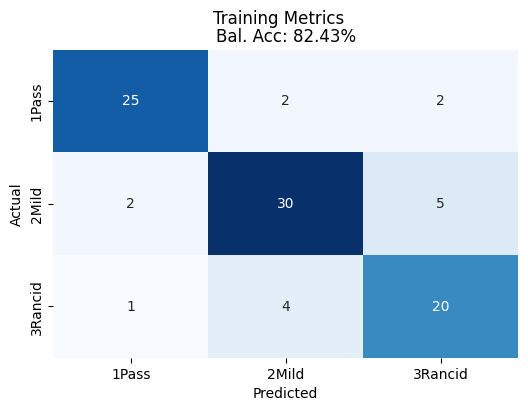

In [23]:
# cnfm = confusion_matrix(grouped_y, train_pred)
# bal_acc = balanced_accuracy_score(grouped_y, train_pred)

# fig = plt.figure(figsize = (6, 4))
# fig.suptitle("Training Metrics")
# ax = fig.add_subplot(111)

# cnfm_settings = {
#     "cmap": "Blues",
#     "cbar": None,
#     "annot": True,
#     "fmt": ".0f",
#     "xticklabels": encoder.classes_,
#     "yticklabels": encoder.classes_,
# }

# ax.set_title(f"Bal. Acc: {bal_acc*100:.2f}%")
# sns.heatmap(
#     cnfm,
#     ax = ax,
#     **cnfm_settings
# )

# ax.set_xlabel('Predicted')
# ax.set_ylabel('Actual')
# # plt.tight_layout()
# plt.show()

In [24]:
f1score = f1_score(grouped_y, train_pred, average=None, labels=encoder.transform(list(encoder.classes_)))
f1score

array([0.87719298, 0.82191781, 0.76923077])

# cross val predict

In [107]:
grouped_X = X_train.groupby(X_train.index).mean()
grouped_y = y_train_encoded.groupby(y_train_encoded.index).mean()

# Calculate CV confusion matrix
kfold = StratifiedGroupKFold(n_splits = 3)

grouped_cv_pred = cross_group_predict(
    trainer.get_pipeline(), 
    X = X_train,
    y = y_train_encoded,
    cv = kfold,
    groups = X_train.index
)

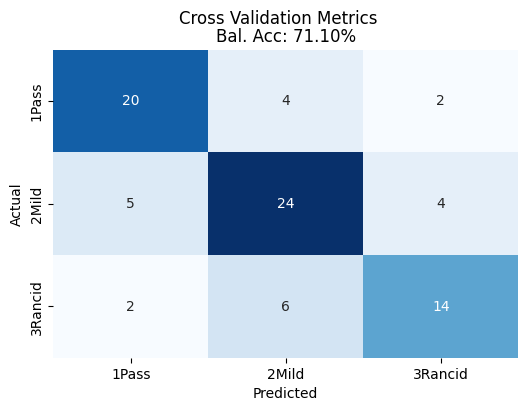

In [108]:
cnfm = confusion_matrix(grouped_y, grouped_cv_pred)
bal_acc = balanced_accuracy_score(grouped_y, grouped_cv_pred)

fig = plt.figure(figsize = (6, 4))
fig.suptitle("Cross Validation Metrics")
ax = fig.add_subplot(111)

ax.set_title(f"Bal. Acc: {bal_acc*100:.2f}%")

cnfm_settings = {
    "cmap": "Blues",
    "cbar": None,
    "annot": True,
    "fmt": ".0f",
    "xticklabels": encoder.classes_,
    "yticklabels": encoder.classes_,
}

sns.heatmap(
    cnfm,
    ax = ax,
    **cnfm_settings
)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# plt.tight_layout()
plt.show()

In [109]:
f1score = f1_score(grouped_y, grouped_cv_pred, average=None, labels=encoder.transform(list(encoder.classes_)))
f1score

array([0.75471698, 0.71641791, 0.66666667])

# blinds predict

In [110]:
X_val, y_val = X_test, y_test

X_val.shape, y_val.shape

((40, 191), (40, 1))

In [111]:
y_val_encoded = pd.Series(
    encoder.transform(y_val),
    index = y_val.index
)

grouped_X_val = X_val.groupby(X_val.index).mean()
grouped_y_val = y_val_encoded.groupby(y_val_encoded.index).mean()

val_pred = trainer.predict(grouped_X_val)

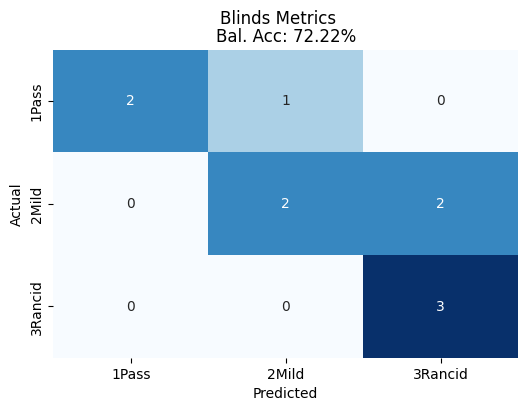

In [112]:
cnfm = confusion_matrix(grouped_y_val, val_pred, labels = encoder.transform(list(encoder.classes_)))
bal_acc = balanced_accuracy_score(grouped_y_val, val_pred)

fig = plt.figure(figsize = (6, 4))
fig.suptitle("Blinds Metrics")
ax = fig.add_subplot(111)

ax.set_title(f"Bal. Acc: {bal_acc*100:.2f}%")

cnfm_settings = {
    "cmap": "Blues",
    "cbar": None,
    "annot": True,
    "fmt": ".0f",
    "xticklabels": encoder.classes_,
    "yticklabels": encoder.classes_,
}

sns.heatmap(
    cnfm,
    ax = ax,
    **cnfm_settings
)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

# plt.tight_layout()
plt.show()

In [32]:
decoded_cnfm = pd.DataFrame(
    confusion_matrix(grouped_y, train_pred),
    index = encoder.classes_,
    columns = encoder.classes_
)

decoded_cnfm.to_csv("../models/automl/train_cnfm.csv")
decoded_cnfm

,1Pass,2Mild,3Rancid
1Pass,25,2,2
2Mild,2,30,5
3Rancid,1,4,20
